In [41]:
%reload_ext autoreload
%autoreload 2

from lib.data_loading import load_measurements, CombinedDataLoader

####

from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax import linen as nn

import matplotlib.pyplot as plt


data_dir = "data"
model_dir = Path("./models")
model_dir.mkdir(parents=True, exist_ok=True)

print(f"Data resides in        : {data_dir}")
print(f"Model will be saved to : {model_dir}")

Data resides in        : data
Model will be saved to : models


In [66]:
import jax, jax.numpy as jnp
from flax import linen as nn
from typing import Tuple, Dict, Any

PRNGKey = jax.random.PRNGKey

from enum import Enum

class TrainingMode(Enum):
    RBM_ONLY  = 0
    COND_ONLY = 1
    JOINT     = 2


class ConditionalRBM(nn.Module):
    num_visible: int               # number of visible units (N)
    num_hidden: int                # number of hidden units (H)
    film_width: int = 64
    k: int = 1                     # CD-k steps
    T: float = 1.0                 # temperature

    def setup(self):
        self.W  = self.param("W", nn.initializers.normal(0.01), (self.num_visible, self.num_hidden))
        self.b  = self.param("b", nn.initializers.zeros, (self.num_visible,))
        self.c0 = self.param("c", nn.initializers.zeros, (self.num_hidden,))

    @nn.compact
    def _conditioner(self, cond_flat: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        x = nn.Dense(self.film_width)(cond_flat)
        x = nn.tanh(x)
        x = nn.Dense(2 * self.num_hidden)(x)
        gamma, beta = jnp.split(x, 2, axis=-1)
        return gamma, beta

    def _free_energy(self,
                     v: jnp.ndarray,
                     W: jnp.ndarray,
                     b: jnp.ndarray,
                     c_mod: jnp.ndarray) -> jnp.ndarray:
        lin_term = -(v @ b)
        hidden_term = jnp.sum(jax.nn.softplus(v @ W + c_mod), axis=-1)
        return lin_term - hidden_term

    def _gibbs_step(self,
                    state: Tuple[jnp.ndarray, PRNGKey],
                    W: jnp.ndarray,
                    b: jnp.ndarray,
                    c_mod: jnp.ndarray,
                    temp: float) -> Tuple[jnp.ndarray, PRNGKey]:
        v, key = state
        key, key_h, key_v = jax.random.split(key, 3)
        h = jax.random.bernoulli(key_h, jax.nn.sigmoid((v @ W + c_mod) / temp)).astype(jnp.float32)
        v = jax.random.bernoulli(key_v, jax.nn.sigmoid((h @ W.T + b) / temp)).astype(jnp.float32)
        return v, key

    def __call__(self, batch: jnp.ndarray, aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, PRNGKey]:
        mode = aux_vars["mode"]
        key = aux_vars["key"]

        # batch contains visible data and conditioning information (B, N, 1 + C)
        data = batch[..., 0].astype(jnp.float32)   # (B, N)
        cond = batch[..., 1:]                      # (B, N, C)
        B, N = data.shape
        cond_flat = cond.reshape(B, -1)            # (B, N * C)

        # select parameter set & compute c_mod
        if mode == TrainingMode.RBM_ONLY:
            W, b, c0 = self.W, self.b, self.c0
            c_mod = c0

        elif mode == TrainingMode.COND_ONLY:
            W = jax.lax.stop_gradient(self.W)
            b = jax.lax.stop_gradient(self.b)
            c0 = jax.lax.stop_gradient(self.c0)
            gamma, beta = self._conditioner(cond_flat)
            c_mod = (1 + gamma) * c0 + beta

        else:  # JOINT
            W, b, c0 = self.W, self.b, self.c0
            gamma, beta = self._conditioner(cond_flat)
            c_mod = (1 + gamma) * c0 + beta

        # Chain initialization
        key, key_init = jax.random.split(key)
        gibbs_chain = jax.random.bernoulli(key_init, 0.5, shape=(B, N)).astype(jnp.float32)

        # Gibbs sampling
        gibbs_step_fn = lambda _, s: self._gibbs_step(s, W, b, c_mod, temp=self.T)
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (gibbs_chain, key_init))
        gibbs_chain = jax.lax.stop_gradient(gibbs_chain)

        # Contrastive Divergence loss
        loss = jnp.mean(self._free_energy(data, W, b, c_mod)) - jnp.mean(self._free_energy(gibbs_chain, W, b, c_mod))
        return loss, { "mode": mode, "key": key }

    @nn.nowrap
    def generate(self, cond: jnp.ndarray, T_schedule: jnp.ndarray, key: PRNGKey) -> Tuple[jnp.ndarray, PRNGKey]:
        # conditioning tensor basically looks like a training batch, but without the data channel (B, N, C)

        B, N, C = cond.shape

        gamma, beta = self._conditioner(cond.reshape(B, -1))
        c_mod = (1 + gamma) * self.c0 + beta

        key, key_init = jax.random.split(key)
        gibbs_chain = jax.random.bernoulli(key_init, 0.5, shape=(B, N)).astype(jnp.float32)  # (k, B, N)

        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W, self.b, c_mod, temp=T_schedule[i])
        gibbs_chain, _ = jax.lax.fori_loop(0, len(T_schedule), gibbs_step_fn, (gibbs_chain, key_init))
        return gibbs_chain, key

In [70]:
import functools

from functools import partial

@partial(jax.jit, static_argnames=("mode",))
def train_step_cond(
        state: TrainState,
        batch: jnp.ndarray,
        mode: TrainingMode,
        key: PRNGKey) -> Tuple[TrainState, jnp.ndarray]:

    aux_vars = {"mode": mode, "key": key}
    loss_fn = lambda params: state.apply_fn({'params': params}, batch, aux_vars)
    (loss, aux_vars), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    return state, loss, aux_vars["key"]


def train_cond_rbm(
        state: TrainState,
        loader: CombinedDataLoader,
        num_epochs: int,
        mode: TrainingMode,
        key: PRNGKey) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[int, Any] = {}
    for epoch in range(num_epochs):
        tot_loss, batches = 0.0, 0

        for batch in loader:
            key, key_batch = jax.random.split(key)
            state, loss, key_batch = train_step_cond(state, batch, mode, key_batch)
            tot_loss += float(loss)
            batches  += 1

        avg_loss = tot_loss / batches
        lr = float(lr_schedule(state.opt_state[0].count))

        metrics[epoch] = dict(loss=avg_loss, lr=lr)
        
        print(f"Epoch {epoch+1}/{num_epochs} │ "
            f"Loss: {avg_loss:+.4f} │ "
            f"Learning Rate: {lr:.5f}")

    return state, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2

    curve_fn = lambda step: low + (high - low) / (1 + jnp.exp(falloff * (jnp.minimum(step, steps) - center_step)))
    return curve_fn

In [72]:
file_path = Path("data/w_aug_ZZZZZZZZ_6400.txt")
data = load_measurements(file_path)

Parsing measurements: 100%|██████████| 6400/6400 [00:00<00:00, 26421.38it/s]


In [74]:
batch_size   = 64
num_qubits   = 8
hidden_units = 16
film_width = 32
k_steps      = 600
num_epochs   = 300
init_lr      = 1e-2
final_lr     = init_lr * 0.1


key_seed = PRNGKey(42)
key, key_params, key_dummy = jax.random.split(key_seed, 3)

model = ConditionalRBM(num_visible=num_qubits, num_hidden=hidden_units, film_width=32, k=k_steps)

batch_dummy = jnp.zeros((batch_size, num_qubits, 3), dtype=jnp.float32)
aux_vars_dummy = {"mode": TrainingMode.JOINT, "key": key_dummy}
variables = model.init({"params": key_params}, batch_dummy, aux_vars_dummy)

aux_vars_dummy = {"mode": TrainingMode.RBM_ONLY, "key": key_dummy}
variables_amp = model.init({"params": key_params}, batch_dummy, aux_vars_dummy)

loader = CombinedDataLoader(data, batch_size=batch_size)

schedule_steps = num_epochs * len(loader)
lr_schedule = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)
optimizer = optax.adam(lr_schedule)

state = TrainState.create(apply_fn=model.apply, params=variables['params'], tx=optimizer)

state, metrics = train_cond_rbm(state, loader, num_epochs=num_epochs, mode=TrainingMode.RBM_ONLY, key=key)

Epoch 1/300 │ Loss: -0.1902 │ Learning Rate: 0.00999
Epoch 2/300 │ Loss: -0.0432 │ Learning Rate: 0.00999
Epoch 3/300 │ Loss: -0.0395 │ Learning Rate: 0.00999
Epoch 4/300 │ Loss: -0.0190 │ Learning Rate: 0.00999
Epoch 5/300 │ Loss: -0.0003 │ Learning Rate: 0.00999
Epoch 6/300 │ Loss: -0.0005 │ Learning Rate: 0.00999
Epoch 7/300 │ Loss: +0.0005 │ Learning Rate: 0.00999
Epoch 8/300 │ Loss: +0.0111 │ Learning Rate: 0.00999
Epoch 9/300 │ Loss: +0.0070 │ Learning Rate: 0.00999
Epoch 10/300 │ Loss: +0.0191 │ Learning Rate: 0.00999
Epoch 11/300 │ Loss: +0.0043 │ Learning Rate: 0.00999
Epoch 12/300 │ Loss: +0.0233 │ Learning Rate: 0.00999
Epoch 13/300 │ Loss: +0.0058 │ Learning Rate: 0.00999
Epoch 14/300 │ Loss: +0.0185 │ Learning Rate: 0.00999
Epoch 15/300 │ Loss: -0.0061 │ Learning Rate: 0.00999
Epoch 16/300 │ Loss: +0.0334 │ Learning Rate: 0.00999
Epoch 17/300 │ Loss: +0.0143 │ Learning Rate: 0.00999
Epoch 18/300 │ Loss: +0.0275 │ Learning Rate: 0.00999
Epoch 19/300 │ Loss: +0.0273 │ Learni

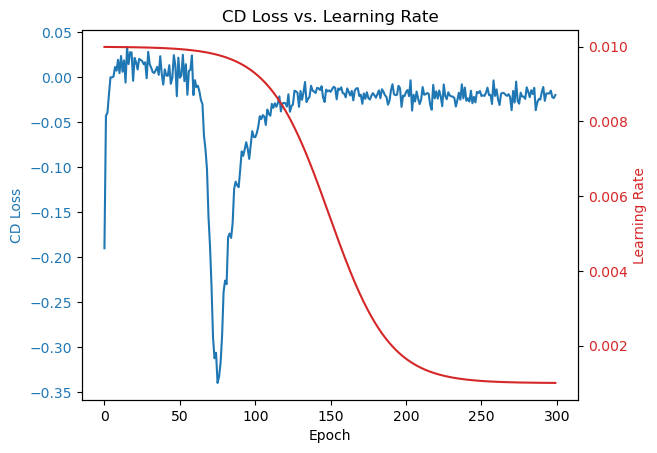

In [75]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")

ax1.plot(epochs, loss_vals, label="CD Loss", color="tab:blue")
ax1.set_ylabel("CD Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax2.set_ylabel("Learning Rate", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("CD Loss vs. Learning Rate")
plt.show()

In [76]:
state, metrics = train_cond_rbm(state, loader, num_epochs=num_epochs, mode=TrainingMode.COND_ONLY, key=key)

Epoch 1/300 │ Loss: +0.0870 │ Learning Rate: 0.00100
Epoch 2/300 │ Loss: +0.0178 │ Learning Rate: 0.00100
Epoch 3/300 │ Loss: -0.0065 │ Learning Rate: 0.00100
Epoch 4/300 │ Loss: +0.0000 │ Learning Rate: 0.00100
Epoch 5/300 │ Loss: -0.0049 │ Learning Rate: 0.00100
Epoch 6/300 │ Loss: -0.0259 │ Learning Rate: 0.00100
Epoch 7/300 │ Loss: -0.0143 │ Learning Rate: 0.00100
Epoch 8/300 │ Loss: -0.0088 │ Learning Rate: 0.00100
Epoch 9/300 │ Loss: -0.0135 │ Learning Rate: 0.00100
Epoch 10/300 │ Loss: -0.0130 │ Learning Rate: 0.00100
Epoch 11/300 │ Loss: -0.0208 │ Learning Rate: 0.00100
Epoch 12/300 │ Loss: -0.0018 │ Learning Rate: 0.00100
Epoch 13/300 │ Loss: -0.0096 │ Learning Rate: 0.00100
Epoch 14/300 │ Loss: -0.0258 │ Learning Rate: 0.00100
Epoch 15/300 │ Loss: -0.0103 │ Learning Rate: 0.00100
Epoch 16/300 │ Loss: -0.0092 │ Learning Rate: 0.00100
Epoch 17/300 │ Loss: -0.0198 │ Learning Rate: 0.00100
Epoch 18/300 │ Loss: -0.0164 │ Learning Rate: 0.00100
Epoch 19/300 │ Loss: -0.0099 │ Learni

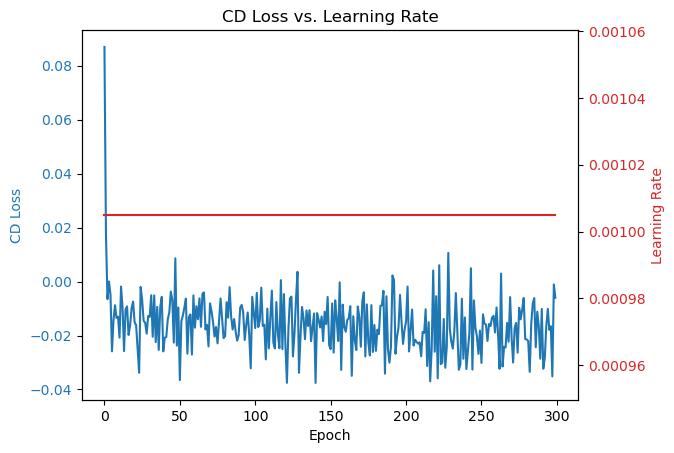

In [77]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")

ax1.plot(epochs, loss_vals, label="CD Loss", color="tab:blue")
ax1.set_ylabel("CD Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax2.set_ylabel("Learning Rate", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("CD Loss vs. Learning Rate")
plt.show()

In [80]:
state, metrics = train_cond_rbm(state, loader, num_epochs=num_epochs, mode=TrainingMode.JOINT, key=key)

Epoch 1/300 │ Loss: +0.0041 │ Learning Rate: 0.00100
Epoch 2/300 │ Loss: -0.0059 │ Learning Rate: 0.00100
Epoch 3/300 │ Loss: -0.0100 │ Learning Rate: 0.00100
Epoch 4/300 │ Loss: -0.0156 │ Learning Rate: 0.00100
Epoch 5/300 │ Loss: -0.0151 │ Learning Rate: 0.00100
Epoch 6/300 │ Loss: -0.0316 │ Learning Rate: 0.00100
Epoch 7/300 │ Loss: -0.0163 │ Learning Rate: 0.00100
Epoch 8/300 │ Loss: -0.0156 │ Learning Rate: 0.00100
Epoch 9/300 │ Loss: +0.0014 │ Learning Rate: 0.00100
Epoch 10/300 │ Loss: -0.0207 │ Learning Rate: 0.00100
Epoch 11/300 │ Loss: -0.0365 │ Learning Rate: 0.00100
Epoch 12/300 │ Loss: +0.0066 │ Learning Rate: 0.00100
Epoch 13/300 │ Loss: -0.0186 │ Learning Rate: 0.00100
Epoch 14/300 │ Loss: -0.0119 │ Learning Rate: 0.00100
Epoch 15/300 │ Loss: -0.0140 │ Learning Rate: 0.00100
Epoch 16/300 │ Loss: -0.0143 │ Learning Rate: 0.00100
Epoch 17/300 │ Loss: -0.0367 │ Learning Rate: 0.00100
Epoch 18/300 │ Loss: -0.0190 │ Learning Rate: 0.00100
Epoch 19/300 │ Loss: -0.0034 │ Learni

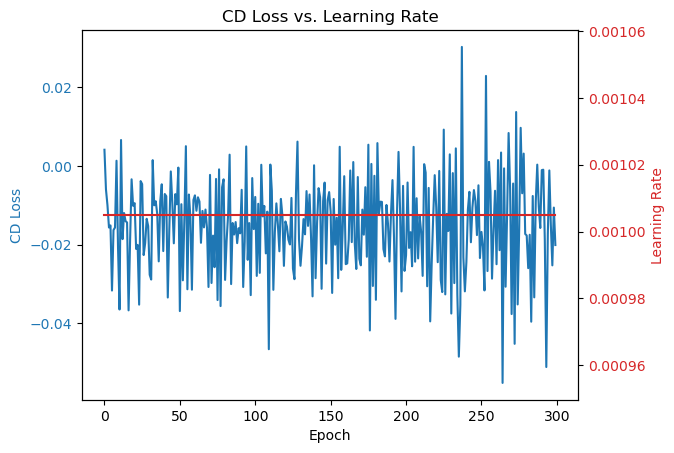

In [81]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")

ax1.plot(epochs, loss_vals, label="CD Loss", color="tab:blue")
ax1.set_ylabel("CD Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax2.set_ylabel("Learning Rate", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("CD Loss vs. Learning Rate")
plt.show()

In [82]:
T_high = 2.0
T_low = 0.01
sampling_steps = 5_000
sigmoid_schedule_fn = get_sigmoid_curve(high=T_high*2, low=T_low, steps=sampling_steps, falloff=0.0013, center_step=0)
sigmoid_schedule = jnp.array([sigmoid_schedule_fn(i) for i in range(sampling_steps)], dtype=jnp.float32)

num_samples = 10_000
dir_bits = jnp.ones((num_samples, model.num_visible, 2), dtype=jnp.int32)

key_sample = PRNGKey(1234)
samples, _ = model.apply({'params': state.params}, dir_bits, sigmoid_schedule, key_sample, method=ConditionalRBM.generate)

# the output samples still have all three channels, we need only want to know the frequencies from the outcome channel
sampled_freq = samples.mean(axis=0)
sampled_freq

Array([0.2705    , 0.0706    , 0.0746    , 0.2748    , 0.24159999,
       0.0469    , 0.0065    , 0.0146    ], dtype=float32)

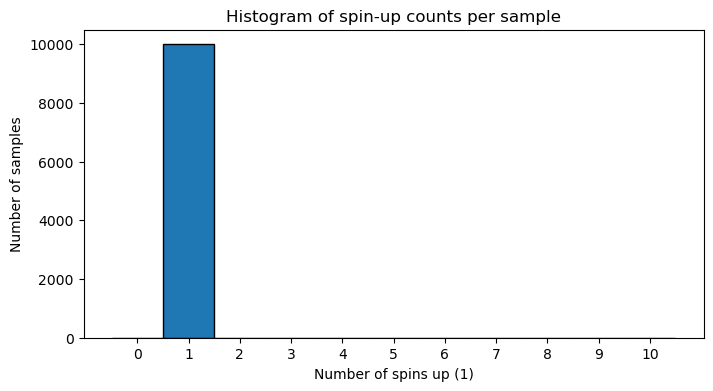

In [83]:
spin_counts = samples.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(12), align='left', edgecolor='black')
plt.xticks(range(11))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()

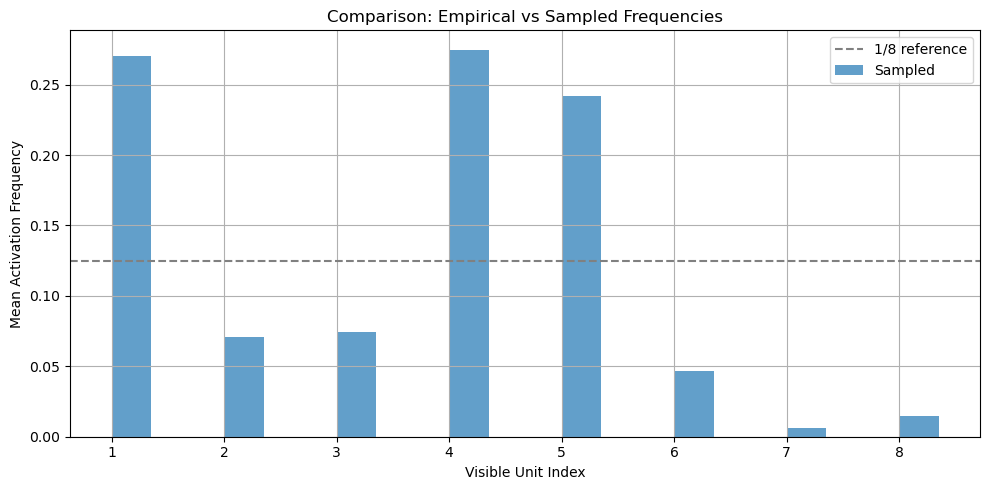

In [84]:
import numpy as np

plt.figure(figsize=(10, 5))
x = np.arange(num_qubits) + 1
width = 0.35

plt.bar(x + width/2, sampled_freq, width, label="Sampled", alpha=0.7)

plt.axhline(1 / num_qubits, linestyle='--', color='gray', label=f'1/{num_qubits} reference')
plt.xlabel("Visible Unit Index")
plt.ylabel("Mean Activation Frequency")
plt.title("Sampled Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [86]:
file_path = Path("data/w_aug_combined.txt")
data = load_measurements(file_path)

Parsing measurements: 100%|██████████| 20000/20000 [00:00<00:00, 25422.43it/s]


In [87]:
loader = CombinedDataLoader(data, batch_size=batch_size)

state, metrics = train_cond_rbm(state, loader, num_epochs=num_epochs, mode=TrainingMode.JOINT, key=key)

Epoch 1/300 │ Loss: +3.8806 │ Learning Rate: 0.00100
Epoch 2/300 │ Loss: +1.8046 │ Learning Rate: 0.00100
Epoch 3/300 │ Loss: +1.0504 │ Learning Rate: 0.00100
Epoch 4/300 │ Loss: +0.6141 │ Learning Rate: 0.00100
Epoch 5/300 │ Loss: +0.3613 │ Learning Rate: 0.00100
Epoch 6/300 │ Loss: +0.2083 │ Learning Rate: 0.00100
Epoch 7/300 │ Loss: +0.1197 │ Learning Rate: 0.00100
Epoch 8/300 │ Loss: +0.0654 │ Learning Rate: 0.00100
Epoch 9/300 │ Loss: +0.0322 │ Learning Rate: 0.00100
Epoch 10/300 │ Loss: +0.0230 │ Learning Rate: 0.00100
Epoch 11/300 │ Loss: +0.0091 │ Learning Rate: 0.00100
Epoch 12/300 │ Loss: +0.0052 │ Learning Rate: 0.00100
Epoch 13/300 │ Loss: +0.0104 │ Learning Rate: 0.00100
Epoch 14/300 │ Loss: +0.0096 │ Learning Rate: 0.00100
Epoch 15/300 │ Loss: +0.0079 │ Learning Rate: 0.00100
Epoch 16/300 │ Loss: +0.0019 │ Learning Rate: 0.00100
Epoch 17/300 │ Loss: -0.0004 │ Learning Rate: 0.00100
Epoch 18/300 │ Loss: +0.0036 │ Learning Rate: 0.00100
Epoch 19/300 │ Loss: +0.0020 │ Learni

In [88]:
T_high = 2.0
T_low = 0.01
sampling_steps = 5_000
sigmoid_schedule_fn = get_sigmoid_curve(high=T_high*2, low=T_low, steps=sampling_steps, falloff=0.0013, center_step=0)
sigmoid_schedule = jnp.array([sigmoid_schedule_fn(i) for i in range(sampling_steps)], dtype=jnp.float32)

num_samples = 10_000
dir_bits = jnp.ones((num_samples, model.num_visible, 2), dtype=jnp.int32)

key_sample = PRNGKey(1234)
samples, _ = model.apply({'params': state.params}, dir_bits, sigmoid_schedule, key_sample, method=ConditionalRBM.generate)

# the output samples still have all three channels, we need only want to know the frequencies from the outcome channel
sampled_freq = samples.mean(axis=0)
sampled_freq

Array([0.    , 0.    , 0.    , 0.    , 0.0043, 0.002 , 0.    , 0.    ],      dtype=float32)

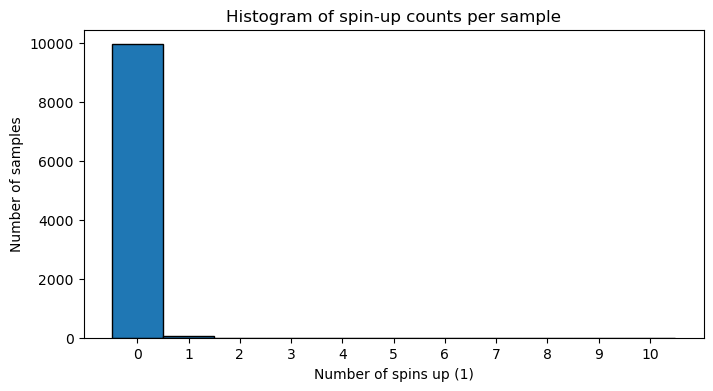

In [89]:
spin_counts = samples.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(12), align='left', edgecolor='black')
plt.xticks(range(11))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()